## Extract metrics

Першим чином розділяємо усі метрики з файлу та записуємо їх у файли з відповідними назвами та колонками time, value

In [49]:
import json
from functools import reduce
from preprocessor import extract_attributes, CallsMetric, DurationMetric

metrics = open('../data/otel/metrics.json', 'r')
Lines = metrics.readlines()
for line in Lines:
    parsed = json.loads(line)
    for resourceMetrics  in parsed['resourceMetrics']:
        serviceName = resourceMetrics
        metadata = extract_attributes(resourceMetrics['resource']['attributes'], {'service.name': 'serviceName'})
        allMetrics = reduce(lambda a, b: a + b, map(lambda o: o.get('metrics', []), resourceMetrics['scopeMetrics']))

        for metric in allMetrics:
            name = metric['name']
            if CallsMetric.match(name):
                metric = CallsMetric(metric)
                metric.write(metadata)
            if DurationMetric.match(name):
                metric = DurationMetric(metric)
                metric.write(metadata)
metrics.close()

## Combine metrics

Читаємо усі файли, трансформуємо дату та робимо похвилину агрегацію, отримуючи середнє значення метрик за період в хвилину

In [2]:
import os
import pandas as pd

resampled = []
for file_name in os.listdir("results"):
    df = pd.read_csv("results/" + file_name)
    df['time'] = pd.to_datetime(df['time'])
    df = df.resample('T', on='time').value.mean()
    df.rename(file_name.split('.')[0], inplace=True)
    resampled.append(df)

df = pd.concat(resampled, axis=1)
df.dropna(inplace=True)

Будуємо графік значень, бачимо кореляцію певних метрик

Text(0.5, 1.0, 'feature-wise values')

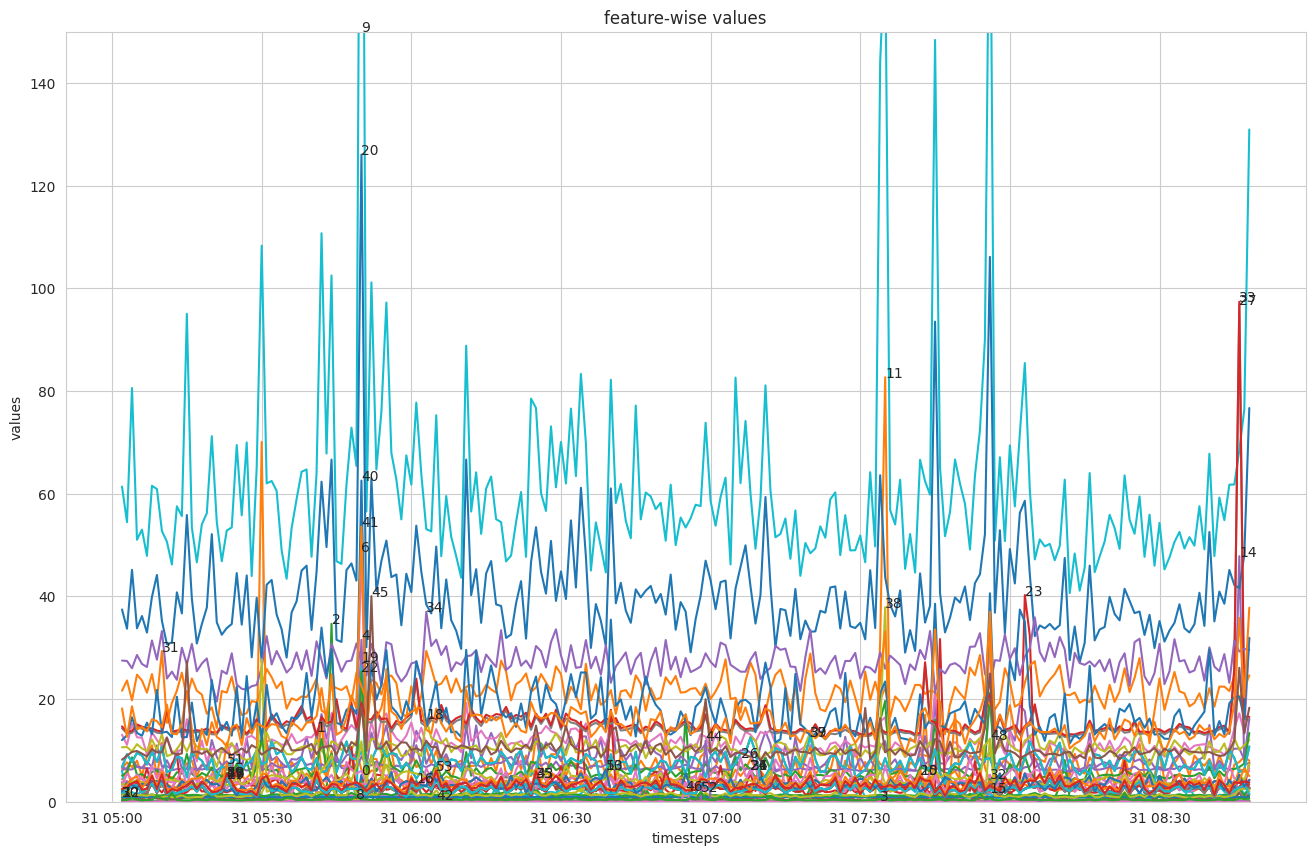

In [3]:
import matplotlib.pyplot as plt
import numpy as np

df_visual = df[5:]

time = df_visual.index
plt.figure(figsize=(16,10), )
for i in range(len(df_visual.columns)):
    target = df_visual.iloc[:,i]
    plt.plot(time, target)
    max_idx = np.argmax(target)
    plt.text(time[max_idx], 150 if target[max_idx] > 150  else target[max_idx], i)

plt.ylim(0, 150)
plt.ylabel('values'); plt.xlabel('timesteps')
plt.title('feature-wise values')


In [4]:
df

,frauddetectionservice_incomingAsync_request_duration,currencyservice_outgoing_requests_without_errors,adservice_outgoing_request_duration,quoteservice_internal_request_duration,shippingservice_outgoing_request_duration,emailservice_outgoing_requests_without_errors,frontend_outgoing_request_duration,paymentservice_incoming_requests_with_errors,paymentservice_internal_request_duration,checkoutservice_outgoing_request_duration,...,accountingservice_incomingAsync_request_duration,productcatalogservice_incoming_request_duration,adservice_internal_request_duration,checkoutservice_internal_requests_without_errors,quoteservice_outgoing_request_duration,accountingservice_incomingAsync_requests_without_errors,adservice_internal_requests_without_errors,emailservice_internal_requests_without_errors,paymentservice_outgoing_request_duration,checkoutservice_incoming_requests_without_errors
time,,,,,,,,,,,,,,,,,,,,,
2023-05-31 04:57:00,0.141367,4.500000,3.515533,0.006642,6.193838,1.500000,339.083934,1.0,0.045248,3526.915691,...,0.018994,10.450681,0.037552,1.500000,3.040207,1.50,6.00,2.250,0.272640,2.062500
2023-05-31 04:58:00,0.227574,6.500000,0.869448,0.008233,9.716434,2.000000,20.915282,1.0,0.106571,92.121116,...,0.023839,11.211843,0.018953,2.000000,7.017856,2.00,3.00,3.000,0.584544,2.875000
2023-05-31 04:59:00,0.191880,6.333333,1.007746,0.007993,11.119389,2.000000,12.105450,1.0,0.061013,78.298951,...,0.044375,12.893746,0.013337,2.000000,5.341826,2.00,2.00,3.000,0.319147,2.666667
2023-05-31 05:00:00,0.287567,5.000000,0.938358,0.007481,8.949378,2.000000,12.898656,1.0,0.064501,58.595091,...,0.031234,10.034911,0.106670,2.000000,3.729403,2.00,3.50,3.000,0.405739,2.625000
2023-05-31 05:01:00,0.135161,9.500000,2.016538,0.007235,11.537387,3.250000,12.129743,1.0,0.059552,59.523624,...,0.060439,8.737969,0.735343,3.250000,3.697700,3.25,2.00,4.875,0.300432,4.156250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 08:44:00,0.498960,3.250000,0.585842,0.017557,9.715526,2.000000,10.576041,1.0,0.054969,61.756499,...,0.022760,9.998784,0.015969,1.333333,3.445229,1.50,4.25,3.000,0.366080,1.583333
2023-05-31 08:45:00,0.103042,7.250000,0.467806,0.012241,10.311744,2.250000,14.247881,1.0,0.051821,61.798523,...,0.017680,11.860217,0.013150,2.750000,3.704940,2.25,2.75,3.375,0.300698,3.781250
2023-05-31 08:46:00,0.121707,7.750000,1.862212,0.010382,10.371015,2.750000,17.216450,1.0,0.073920,68.476030,...,0.247708,26.091970,0.018832,2.750000,5.244118,2.75,5.25,4.125,0.637424,3.656250


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 2023-05-31 04:57:00 to 2023-05-31 08:48:00
Freq: T
Data columns (total 54 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   frauddetectionservice_incomingAsync_request_duration         232 non-null    float64
 1   currencyservice_outgoing_requests_without_errors             232 non-null    float64
 2   adservice_outgoing_request_duration                          232 non-null    float64
 3   quoteservice_internal_request_duration                       232 non-null    float64
 4   shippingservice_outgoing_request_duration                    232 non-null    float64
 5   emailservice_outgoing_requests_without_errors                232 non-null    float64
 6   frontend_outgoing_request_duration                           232 non-null    float64
 7   paymentservice_incoming_requests_wi

In [6]:
df.describe()

,frauddetectionservice_incomingAsync_request_duration,currencyservice_outgoing_requests_without_errors,adservice_outgoing_request_duration,quoteservice_internal_request_duration,shippingservice_outgoing_request_duration,emailservice_outgoing_requests_without_errors,frontend_outgoing_request_duration,paymentservice_incoming_requests_with_errors,paymentservice_internal_request_duration,checkoutservice_outgoing_request_duration,...,accountingservice_incomingAsync_request_duration,productcatalogservice_incoming_request_duration,adservice_internal_request_duration,checkoutservice_internal_requests_without_errors,quoteservice_outgoing_request_duration,accountingservice_incomingAsync_requests_without_errors,adservice_internal_requests_without_errors,emailservice_internal_requests_without_errors,paymentservice_outgoing_request_duration,checkoutservice_incoming_requests_without_errors
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.0,232.000000,232.000000,...,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,0.200456,6.945402,1.092138,0.011509,9.166808,2.472342,13.447425,1.0,0.091138,77.105714,...,0.079822,10.572400,0.039921,2.446480,4.471027,2.464440,3.442888,3.708513,0.420221,3.246184
std,0.394417,2.103906,2.556747,0.016767,3.072208,0.736581,21.784015,0.0,0.064157,228.627170,...,0.778094,3.122619,0.160837,0.734044,1.360185,0.703585,0.907421,1.104872,0.225870,0.992781
min,0.060148,2.000000,0.423875,0.006484,5.759762,1.000000,6.914559,1.0,0.038400,40.650806,...,0.013990,8.009277,0.010460,1.000000,3.013113,1.000000,1.250000,1.500000,0.198656,1.125000
25%,0.097184,5.250000,0.629554,0.007853,6.929445,2.000000,10.402019,1.0,0.059136,50.747276,...,0.019744,9.375128,0.014617,2.000000,3.656709,2.000000,2.750000,3.000000,0.309658,2.523438
50%,0.119441,6.875000,0.720679,0.009516,8.514708,2.500000,11.421528,1.0,0.070597,56.896834,...,0.022704,9.859636,0.018142,2.333333,4.154011,2.333333,3.500000,3.750000,0.366795,3.177083
75%,0.167499,8.333333,0.844269,0.011672,10.297790,3.000000,12.669616,1.0,0.097240,64.169424,...,0.028503,10.652816,0.022362,3.000000,4.821347,3.000000,4.000000,4.500000,0.433243,3.890625
max,5.244318,13.750000,34.673212,0.256248,31.532086,5.000000,339.083934,1.0,0.638704,3526.915691,...,11.874191,40.057582,2.228787,4.500000,12.188361,5.000000,6.250000,7.500000,1.921789,6.041667


<Axes: >

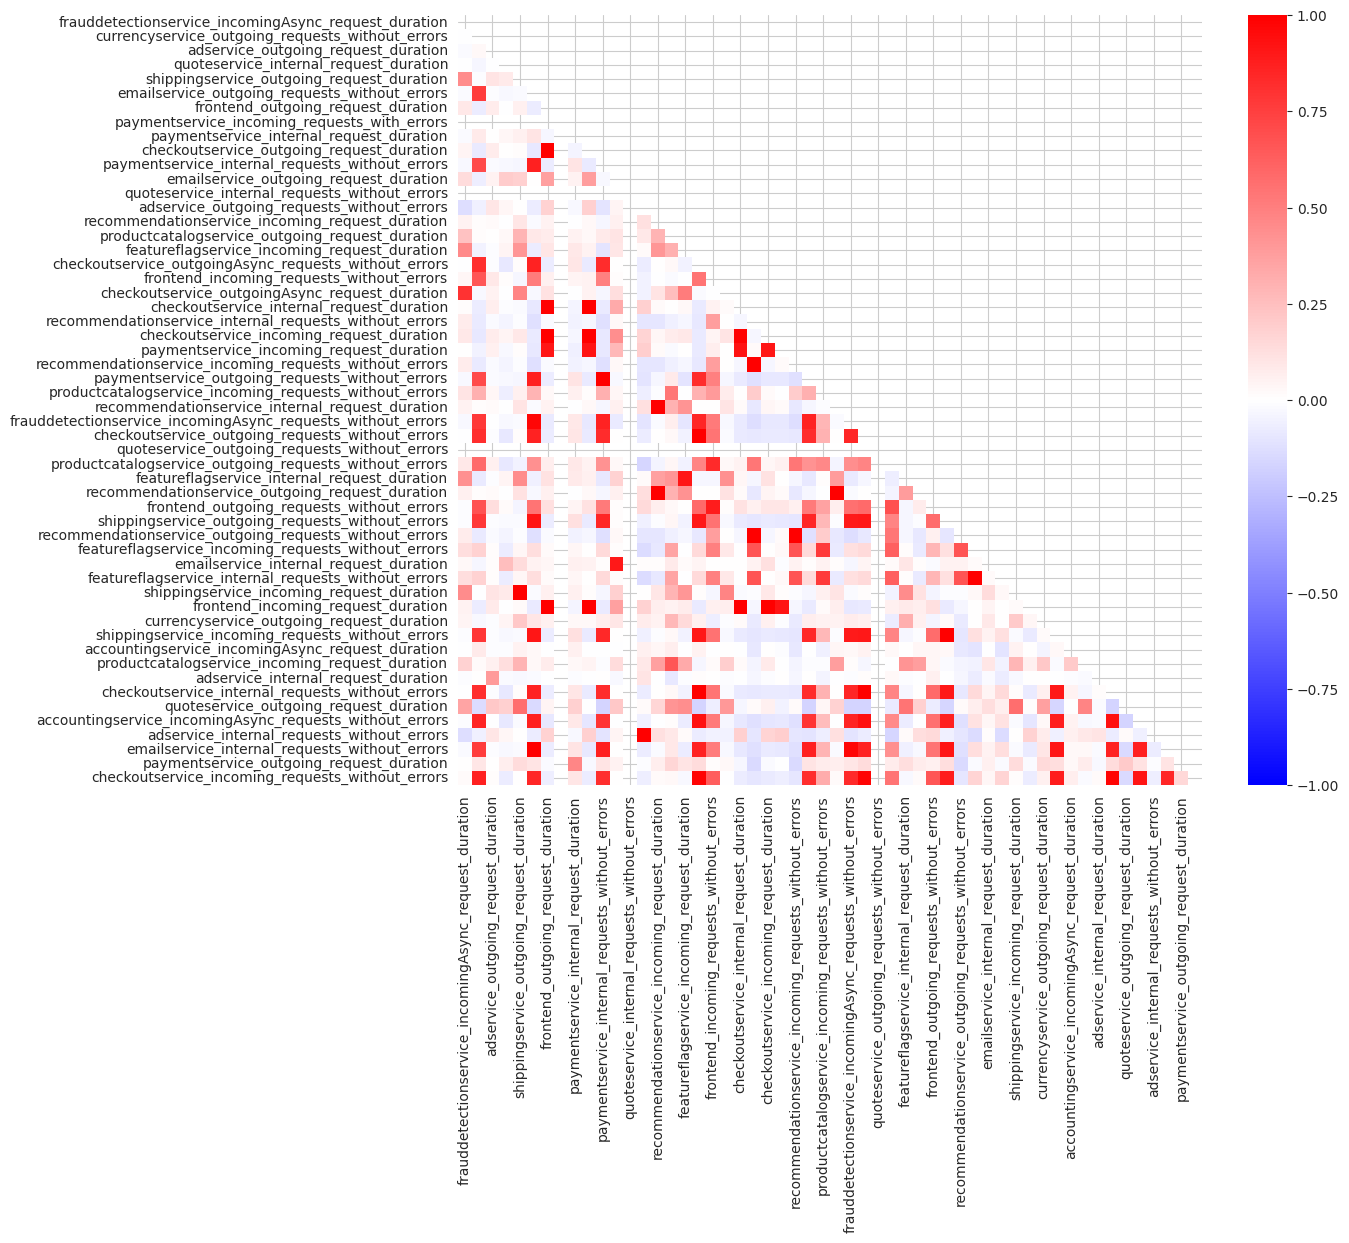

In [23]:
import seaborn as sns

mask = np.triu(np.ones_like(df.corr(), dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), mask=mask, cmap='bwr', vmin=-1, vmax=1)

## Analyze metrics using PCA

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

rec_errors_samples = {}
rec_errors_features = {}

for i, (past_id,future_id) in enumerate(
        TimeSeriesSplit(10).split(df)
):
    scaler = StandardScaler()
    pca = PCA(0.7, random_state=33)
    pca.fit(scaler.fit_transform(df.iloc[past_id]))

    df_inverse = pca.inverse_transform(
        pca.transform(
            scaler.transform(df.iloc[future_id])
        )
    )
    time = df.iloc[past_id[-1]].name
    diff = scaler.transform(df.iloc[future_id]) - df_inverse
    rec_errors_samples[time] = np.linalg.norm(diff, axis=1)
    rec_errors_features[time] = np.linalg.norm(diff, axis=0)

print(rec_errors_samples.keys())

dict_keys([Timestamp('2023-05-31 05:18:00'), Timestamp('2023-05-31 05:39:00'), Timestamp('2023-05-31 06:00:00'), Timestamp('2023-05-31 06:21:00'), Timestamp('2023-05-31 06:42:00'), Timestamp('2023-05-31 07:03:00'), Timestamp('2023-05-31 07:24:00'), Timestamp('2023-05-31 07:45:00'), Timestamp('2023-05-31 08:06:00'), Timestamp('2023-05-31 08:27:00')])


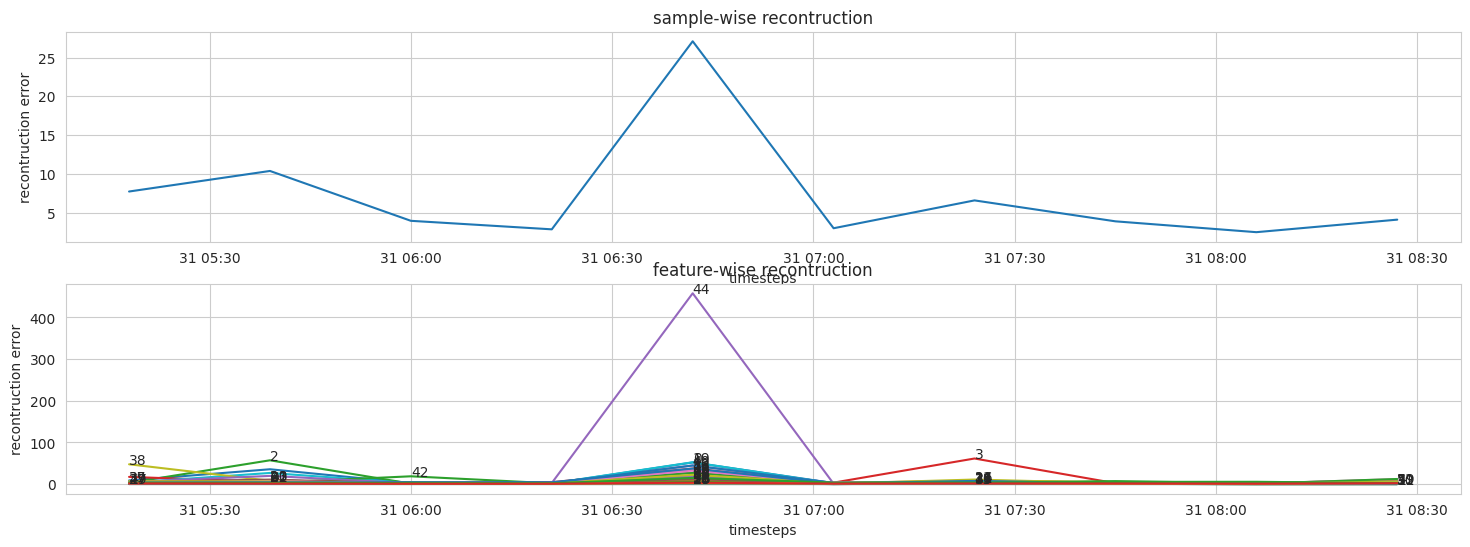

In [9]:
plt.figure(figsize=(18,6))
plt.subplot(2,1,1)
plt.plot(list(rec_errors_samples.keys()),
         [np.mean(r) for r in rec_errors_samples.values()])
plt.ylabel('recontruction error'); plt.xlabel('timesteps')
plt.title('sample-wise recontruction')

plt.subplot(2,1,2)
time = list(rec_errors_features.keys())
for i in range(len(df.columns)):
    rec = []
    for r in rec_errors_features.values():
        rec.append(r[i])
    plt.plot(time, rec)
    max_idx = np.argmax(rec)
    plt.text(time[max_idx], rec[max_idx], i)
plt.ylabel('recontruction error'); plt.xlabel('timesteps')
plt.title('feature-wise recontruction')

plt.show()

In [10]:
for i, col in enumerate(df.columns):
    print(f'{i} - {col}')

0 - frauddetectionservice_incomingAsync_request_duration
1 - currencyservice_outgoing_requests_without_errors
2 - adservice_outgoing_request_duration
3 - quoteservice_internal_request_duration
4 - shippingservice_outgoing_request_duration
5 - emailservice_outgoing_requests_without_errors
6 - frontend_outgoing_request_duration
7 - paymentservice_incoming_requests_with_errors
8 - paymentservice_internal_request_duration
9 - checkoutservice_outgoing_request_duration
10 - paymentservice_internal_requests_without_errors
11 - emailservice_outgoing_request_duration
12 - quoteservice_internal_requests_without_errors
13 - adservice_outgoing_requests_without_errors
14 - recommendationservice_incoming_request_duration
15 - productcatalogservice_outgoing_request_duration
16 - featureflagservice_incoming_request_duration
17 - checkoutservice_outgoingAsync_requests_without_errors
18 - frontend_incoming_requests_without_errors
19 - checkoutservice_outgoingAsync_request_duration
20 - checkoutservice_i

In [25]:
df.iloc[-117:-107,44]

time
2023-05-31 06:52:00     0.036617
2023-05-31 06:53:00     0.021172
2023-05-31 06:54:00     0.028862
2023-05-31 06:55:00     0.028755
2023-05-31 06:56:00     0.018919
2023-05-31 06:57:00     0.018767
2023-05-31 06:58:00     0.023667
2023-05-31 06:59:00    11.874191
2023-05-31 07:00:00     0.044219
2023-05-31 07:01:00     0.029200
Freq: T, Name: accountingservice_incomingAsync_request_duration, dtype: float64

<Axes: >

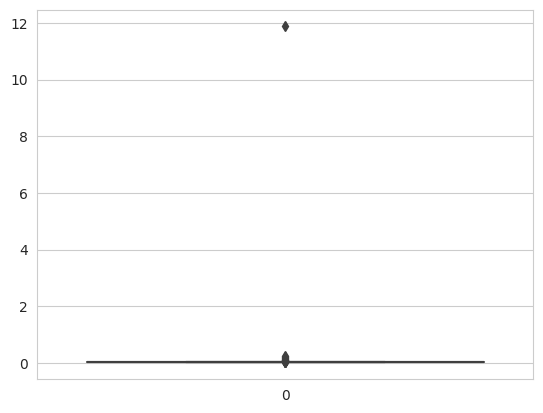

In [12]:
sns.boxplot(df.iloc[:,44])

In [13]:
pca.explained_variance_ratio_

array([0.25880818, 0.12586013, 0.10682314, 0.10224608, 0.04962868,
       0.04030065, 0.03729633])

## Analyze metrics using graph network

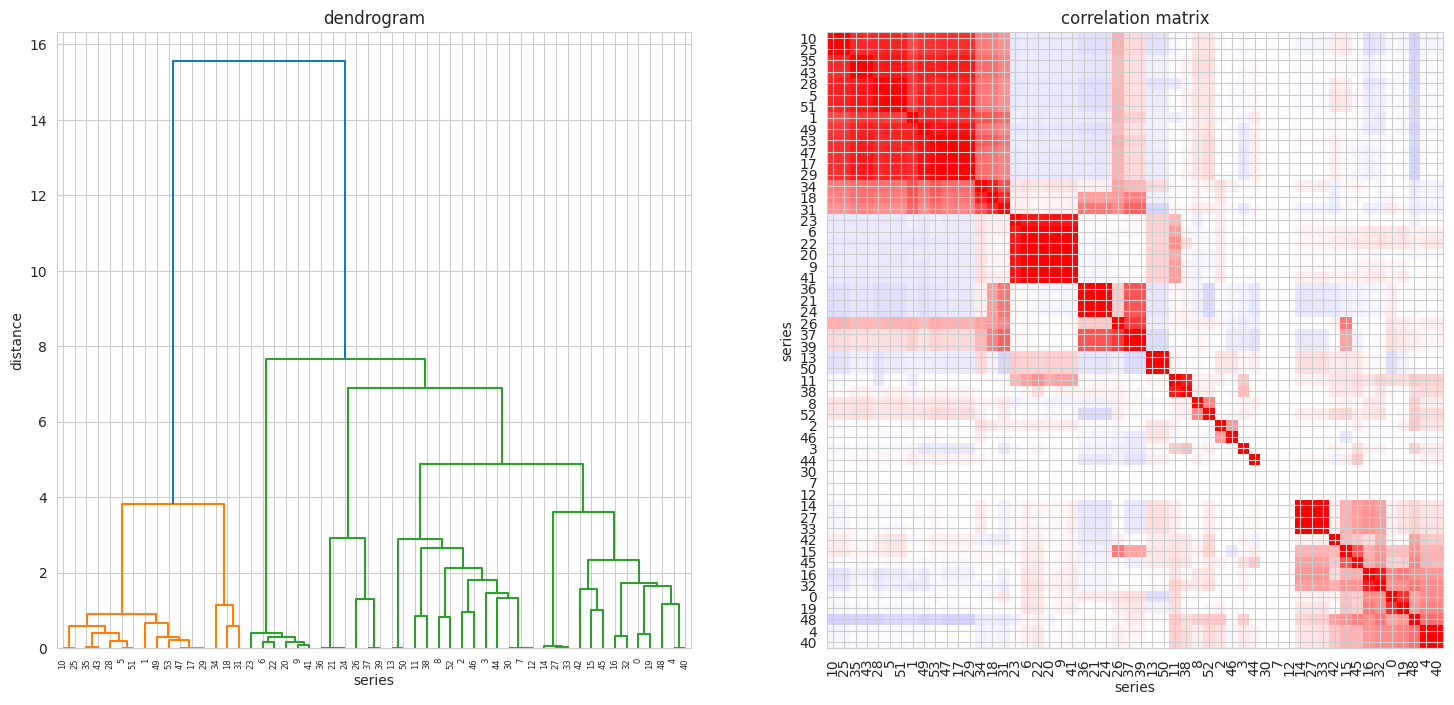

<Axes: xlabel='time'>

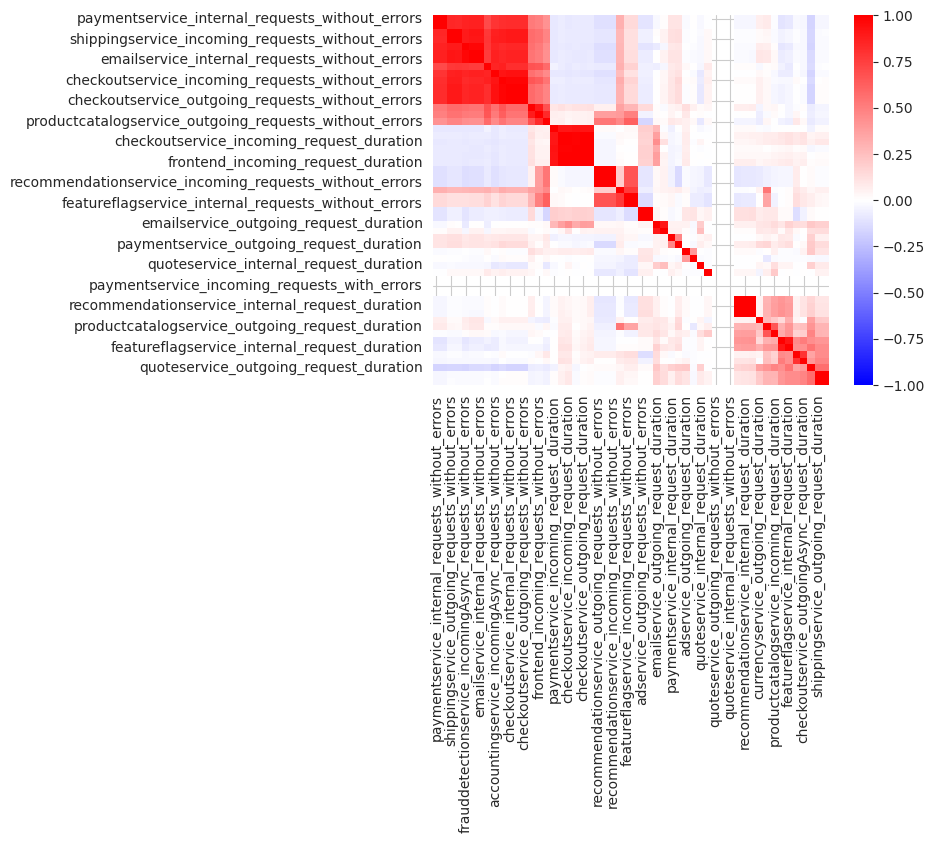

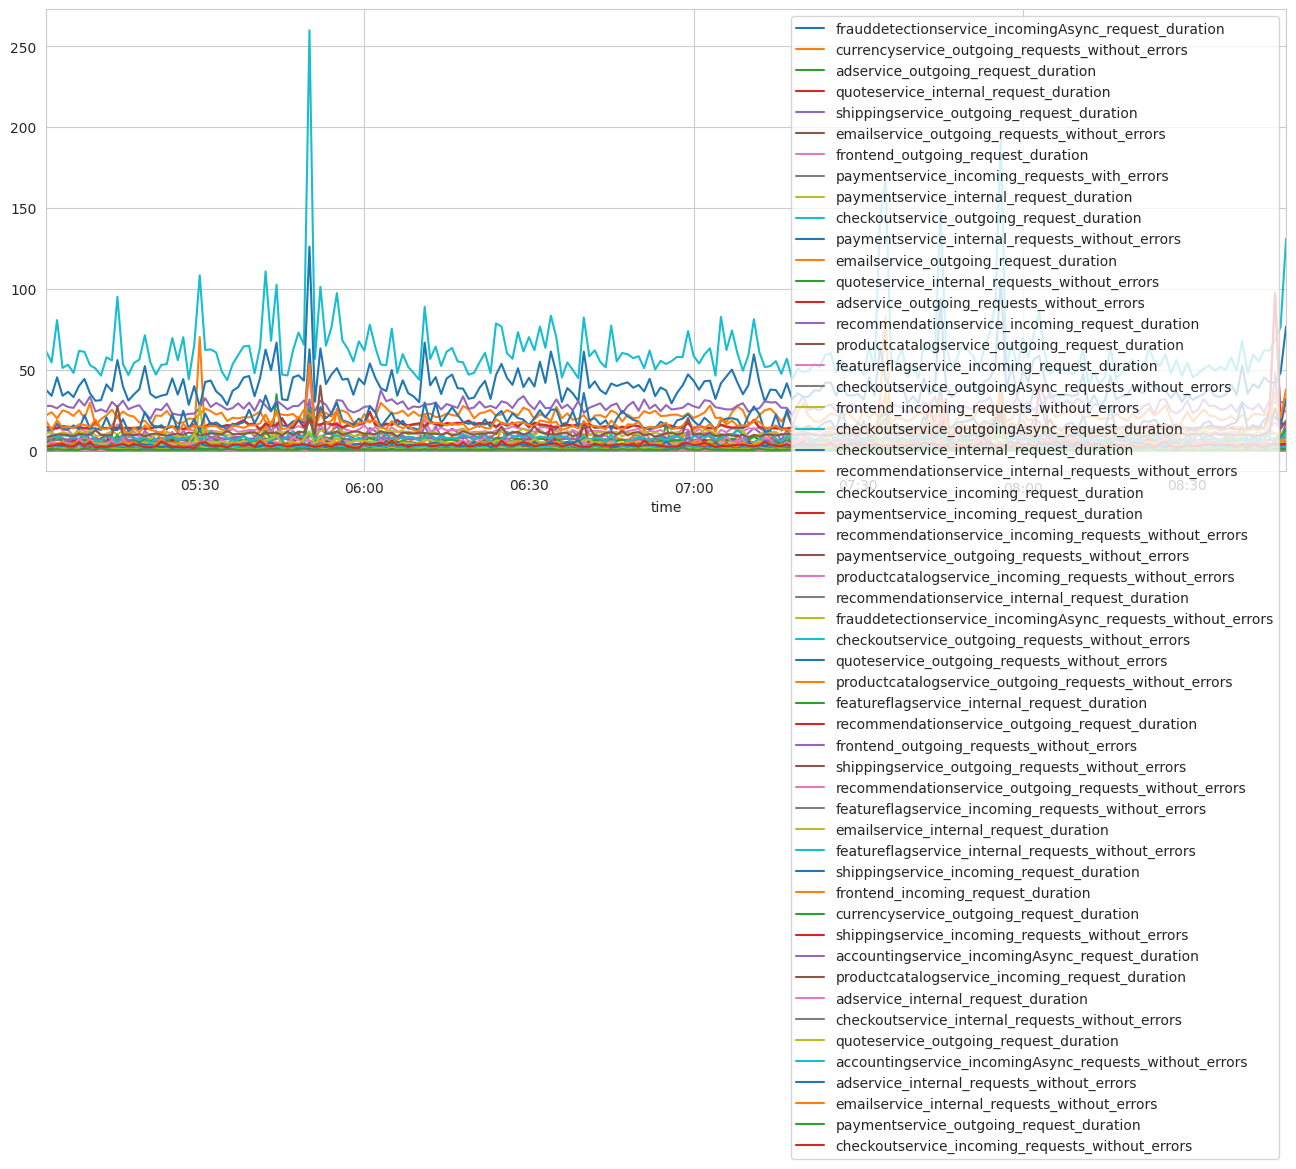

In [22]:
import scipy.cluster.hierarchy as sch
from sklearn.metrics import pairwise_distances
# corr_mat = pd.DataFrame(pairwise_distances(df.T, metric='correlation'))

corr_mat = df.corr()
corr_mat.fillna(0,inplace=True)
d = sch.distance.pdist(corr_mat)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)


labels = dendrogram['leaves']

corr_mat_cluster = pd.concat([df.iloc[:,[i]] for i in labels], axis=1).corr()

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
dendrogram = sch.dendrogram(L, no_plot=False)
plt.title('dendrogram')
plt.ylabel('distance'); plt.xlabel('series')
plt.subplot(1,2,2)
plt.imshow(corr_mat_cluster, cmap='bwr', vmin=-1, vmax=1)
plt.title('correlation matrix')
plt.ylabel('series'); plt.xlabel('series')
plt.xticks(range(len(df.columns)), labels, rotation=90)
plt.yticks(range(len(df.columns)), labels)
plt.show()

sns.heatmap(corr_mat_cluster, annot=False, cmap='bwr', vmin=-1, vmax=1)
df.iloc[5:].plot(figsize=(16,6))


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

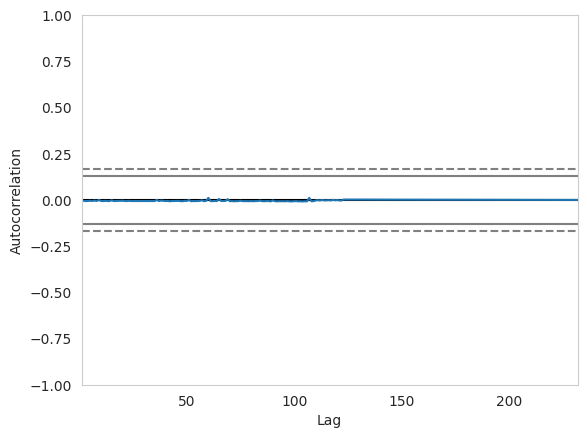

In [15]:
pd.plotting.autocorrelation_plot(df.iloc[:,44])

LinAlgError: 23-th leading minor of the array is not positive definite

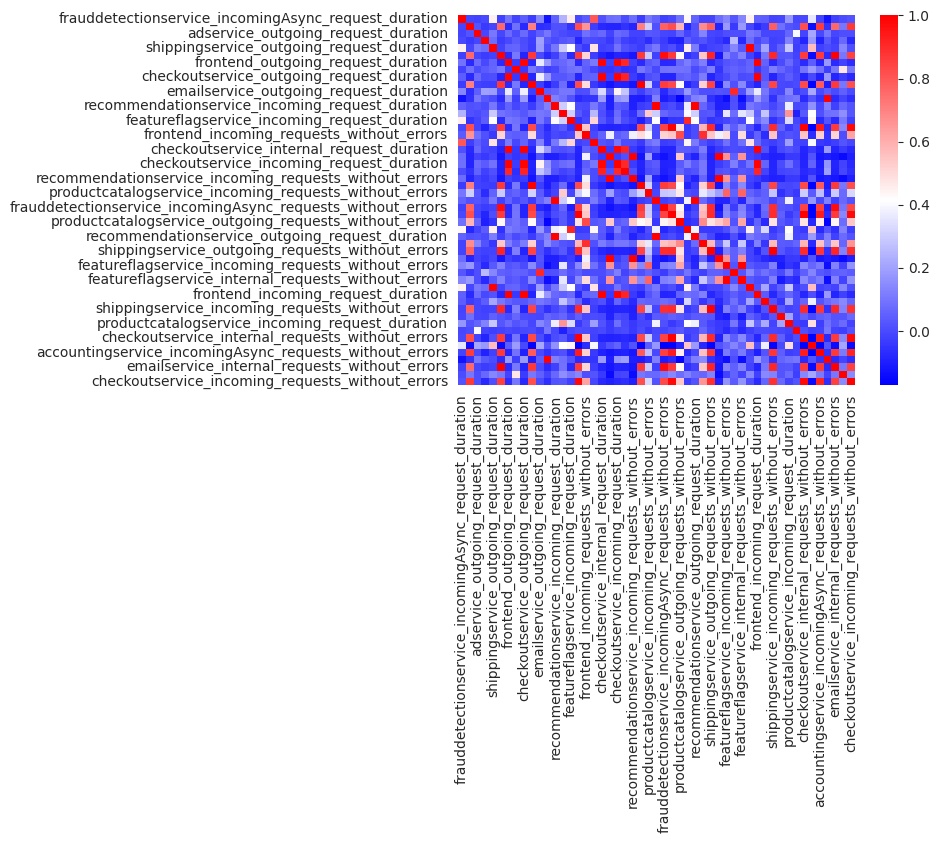

In [16]:
from statsmodels.tsa.vector_ar.var_model import VAR
AIC = {}
best_aic, best_order = np.inf, 0

cleaned_df = df.drop(df.columns[[7,12,30]], axis=1)
train = cleaned_df.iloc[:140]

sns.heatmap(cleaned_df.corr(), annot=False, cmap='bwr')

for i in range(1,50):
    model = VAR(endog=train)
    var_result = model.fit(maxlags=i)
    AIC[i] = var_result.aic

    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i

print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

In [ ]:
from sklearn.cluster import DBSCAN

network_ano = {}
dbscan = DBSCAN(eps=0.6, min_samples=1, metric="precomputed")

for i, (past_id,_) in enumerate(
        TimeSeriesSplit(10, max_train_size=300).split(df)
):
    corr_mat = df.iloc[past_id].corr()
    corr_mat.fillna(0,inplace=True)
    preds = dbscan.fit_predict(
        corr_mat
    )
    print(preds)
    if (preds > 0).any():
        ano_features = list(df.columns[np.where(preds > 0)[0]])
        network_ano[past_id[-1]] = ano_features
    else:
        network_ano[past_id[-1]] = None

print(network_ano)

In [ ]:
### PLOT DBSCAN DETECTED ANOMALIES ###

roll_corr = df.rolling(300).corr()

for ano_loc,ano in network_ano.items():
    if ano is not None:
        for ano_feat in network_ano[ano_loc]:
            roll_corr[ano_feat].unstack().plot(
                legend=False, figsize=(11,6),
                title=f"{ano_feat} rolling correlation",
                ylabel='correlation', xlabel='timesteps'
            )
            plt.axvline(ano_loc, linestyle='--', c='black')
            plt.show()

In [ ]:
import numpy as np

def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

def is_anomaly(data, pca, threshold):
    pca_data = pca.transform(data)
    restored_data = pca.inverse_transform(pca_data)
    loss = np.sum((data - restored_data) ** 2)
    return loss > threshold

In [ ]:

reconstruction_errors = get_anomaly_scores(df, df_restored)
print(reconstruction_errors)
plt.figure(figsize = (8,4))
sns.lineplot(data=reconstruction_errors)
for index, row in df.iterrows():
    if is_anomaly([row], pca, 0.4):
        plt.axvline(row.name, color='r', alpha=0.2)